# **Models**

The various models learned in class were implemented to attempt prediction of the wearer's arm movements based upon the output of the six sensors embedded in the shirt. The data used in these models were from a single subject, pooled across all three trials collected in the protocol. The subject data was taken from subject #4, because that particular data set had the fewest outliers as discussed in the **Data Description and Initial EDA** section. Additionally, due to the high frequency of the collecte data, the data was downsampled to reduce the training time of the models. 



**Train Test Split**
The data was split as a function of time - with the first 80% of the data used as the training set, and the last 20% reserved for testing. Initially, we had done a train_test_split randomly, however this yields artificially inflated test scores of the models because in the actual application of the shirt, it is impossible to predict\results based on future data.

## **A. Data Preparation and Cleaning**

In [23]:
plt.style.use('ac209a.mplstyle')

In [24]:
def standardize(X, X_ref):
    mean = np.mean(X_ref)
    std = np.std(X_ref)
    return (X-mean)/std

In [25]:
def normalize(X, X_ref):
    return (X-np.min(X_ref))/(np.max(X_ref)-np.min(X_ref))

In [26]:
def deriv_1st(df, features):
    prev = df.iloc[0:-2]
    nxt = df.iloc[2:]
    new_features = [f+'_1st' for f in features]
    results = pd.DataFrame(nxt[features].values - prev[features].values, columns=new_features)
    time_diff = pd.DataFrame(nxt['t'].values-prev['t'].values)
    for feature in new_features:
        results[feature] = results[[feature]].div(time_diff.values)
    return results

In [27]:
def deriv_2nd(df, features):
    prev = df.iloc[0:-2]
    now = df.iloc[1:-1]
    nxt = df.iloc[2:]
    new_features = [f+'_2nd' for f in features]
    results = pd.DataFrame(nxt[features].values-2*now[features].values+prev[features].values, columns=new_features)
    time_diff = pd.DataFrame((nxt['t'].values-now['t'].values)*(now['t'].values-prev['t'].values))
    for feature in new_features:
        results[feature] = results[[feature]].div(time_diff.values)
    return results

In [28]:
def prev_values(df, features, num):
    for i in range(1, num+1):
        new_features = [f+'_prev_'+str(i) for f in features]
        prev_df = df[features].shift(i)
        prev_df.columns = new_features
        df = pd.concat([df, prev_df], axis=1)
    return df.dropna()

In [29]:
def add_features(df, features, angs, if_1st_deriv=False, if_2nd_deriv=False, num_prev=0):
    if if_1st_deriv: 
        df_1st_deriv = deriv_1st(df, features)
    else:
        df_1st_deriv = pd.DataFrame()
    if if_2nd_deriv:
        df_2nd_deriv = deriv_2nd(df, features)
    else:
        df_2nd_deriv = pd.DataFrame()
    results = pd.concat([pd.DataFrame(df[1:-1].values, columns=df.columns), df_1st_deriv, df_2nd_deriv], axis=1)
    results = prev_values(results, features, num_prev).drop('t', axis=1)
    return results.drop(columns=angs), results[angs]

In [30]:
# def load_data(names, nums, tests):
#     appended_data = []
#     count = 0

#     for number in nums:
#         for test in tests:
#             for name in names:
#                 file_dir = 'data/' + name + '_t' + str(number) + test + '.txt'
#                 data = pd.read_csv(file_dir, header=None,
#                                    names=['t','s1','s2','s3','s4','s5','s6','hf','ab','ir'])
#                 print(file_dir)
#                 appended_data.append(data)
#                 if count > 0:
#                     appended_data[count].t = appended_data[count].t + max(appended_data[count-1].t)
#                 count += 1
#     df = pd.concat(appended_data, ignore_index=True)
#     return df

In [31]:
def load_data(names, nums, tests, features, angs, if_1st_deriv=False, if_2nd_deriv=False, num_prev=0):
    X_list = []
    y_list = []

    for number in nums:
        for test in tests:
            for name in names:
                file_dir = 'data/' + name + '_t' + str(number) + test + '.txt'
                data = pd.read_csv(file_dir, header=None,
                                   names=['t','s1','s2','s3','s4','s5','s6','hf','ab','ir'])
                data = data.iloc[::20]
                X_df, y_df = add_features(data, features, angs, if_1st_deriv=if_1st_deriv, if_2nd_deriv=if_2nd_deriv, num_prev=num_prev)
                X_list.append(X_df)
                y_list.append(y_df)
                
    X_return = pd.concat(X_list)
    y_return = pd.concat(y_list)
    return X_return, y_return

In [32]:
def calc_plot_arrays(y, yhat):
    x_list = []
    num_list = []
    mean_list = []
    std_list = []
    mae_list = []
    rmse_list = []
    
    for val in np.arange(math.floor(min(y)), math.ceil(max(y))):
        idx = (y>val)&(y<val+1)
        y_pred = np.array(yhat)[np.where(idx)]
        y_true = np.array(y)[np.where(idx)]
        if len(y_true) > 0:
            x_list.append(np.mean(y_true))
            num_list.append(len(y_true))
            mean_list.append(np.mean(y_pred))
            std_list.append(np.std(y_pred))
            mae_list.append(mean_absolute_error(y_true=y_true, y_pred=y_pred))
            rmse_list.append(np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)))
        
    plot_dict = {'x_arr': x_list, 'num_arr':num_list, 'mean_arr':mean_list,
                 'std_arr': std_list, 'mae_arr':mae_list, 'rmse_arr':rmse_list}
    
    return plot_dict


In [33]:
def display_result(model, X_train, y_train, X_test, y_test, plot=False):
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    r2_train = r2_score(y_train, yhat_train)
    r2_test = r2_score(y_test, yhat_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_true=y_train, y_pred=yhat_train))
    rmse_test = np.sqrt(mean_squared_error(y_true=y_test, y_pred=yhat_test))
    
    mae_train = mean_absolute_error(y_true=y_train, y_pred=yhat_train)
    mae_test = mean_absolute_error(y_true=y_test, y_pred=yhat_test)
    
    plot_dict_train = calc_plot_arrays(y_train, yhat_train)
    plot_dict_test = calc_plot_arrays(y_test, yhat_test)
    
    mean_std_train = np.mean(plot_dict_train['std_arr'])
    mean_std_test = np.mean(plot_dict_test['std_arr'])
    
    dict_train = {'r2':r2_train, 'mean_std':mean_std_train, 'rmse':rmse_train, 'mae':mae_train}
    dict_test = {'r2':r2_test, 'mean_std':mean_std_test, 'rmse':rmse_test, 'mae':mae_test}
    
    if plot:
        fig, axs = plt.subplots(2,2, figsize=(30,20))
        for case in range(0,2):
            if case == 0: 
                plot_dict = plot_dict_train
                plt_y = y_train
                title = 'Train'
            else: 
                plot_dict = plot_dict_test
                plt_y = y_test
                title = 'Test'

            plt_x = plot_dict['x_arr']
            plt_mean = np.array(plot_dict['mean_arr'])
            plt_std = np.array(plot_dict['std_arr'])

            axs[0,case].plot(plt_x, plt_mean)
            axs[0,case].fill_between(plt_x, plt_mean-plt_std, plt_mean+plt_std, alpha=0.3)
            axs[0,case].plot([min(plt_y), max(plt_y)], [min(plt_y), max(plt_y)], '--')
            axs[0,case].set_xlabel('True Angles')
            axs[0,case].set_ylabel('Predicted Angles')
            axs[0,case].set_title(title)

            axs[1,case].plot(plt_x, plot_dict['rmse_arr'], label='RMSE')
            axs[1,case].plot(plt_x, plot_dict['mae_arr'], label='MAE')
            axs[1,case].set_xlabel('True Angles')
            axs[1,case].set_ylabel('Error')
            axs[1,case].set_title(title)
            axs[1,case].legend()
        plt.show()
    result_df = pd.DataFrame([dict_train, dict_test], index=['Train','Test'])[['r2','mean_std','mae','rmse']]
    return result_df, dict_train, dict_test, plot_dict_train, plot_dict_test
    

In [149]:
def display_all_results(model, X_df, df, if_display=True, if_plot=False, 
                        if_stand=False, if_norm=False,
                        if_PCA=False, poly_deg=1):
    frames = []
    sens = ['s'+str(k) for k in range(1,n_sens+1)]
    angs = ['ab', 'hf', 'ir']
    models = []
    poly = PolynomialFeatures(degree=poly_deg)
    
    X_train, X_test, y_train, y_test = train_test_split(X_df, df[angs], test_size=0.2, shuffle=False) #, random_state=42)
        
    if if_stand: 
        X_test = standardize(X_test, X_train)
        X_train = standardize(X_train, X_train)

    if if_norm:
        X_test = normalize(X_test, X_train)
        X_train = normalize(X_train, X_train)
                
    if poly_deg > 1:
        X_train_add = pd.DataFrame(poly.fit_transform(X_train[sens]))
        X_test_add = pd.DataFrame(poly.fit_transform(X_test[sens]))
        
        X_train = pd.concat([pd.DataFrame(X_train.values, columns=X_train.columns), 
                             X_train_add], axis=1).drop(sens, axis=1)
        X_test = pd.concat([pd.DataFrame(X_test.values, columns=X_test.columns), 
                            X_test_add], axis=1).drop(sens, axis=1)
    
    if if_PCA:
        # Note: should normalize before applying PCA
        n = X_train.shape[1]
        pca = PCA(n).fit(X_train)
        i = 1
        while np.sum(pca.explained_variance_ratio_[:i]) < 0.95:
            i += 1
        print([n, i])
        pca = PCA(i).fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    
    for i,a in enumerate(angs):
        model.fit(X_train, y_train[a])
        if if_plot == True: print(f'\n********** {a}: **********\n')
        results = display_result(model, X_train, y_train[a], X_test, y_test[a], plot=if_plot)
        frames.append(results[0])
        models.append(model)
        
    if if_display == True: display(pd.concat(frames, keys=angs))
        
    return frames, models
    

In [35]:
def find_best_param(scores_list, params, param_name):
    for ind, score in enumerate(scores_list):
        best_score = np.max(score)
        best_ind = np.argmax(score)
        best_param = params[best_ind]
        print(angs[ind] + ':')
        print("The best model has " + param_name + " of {}.".format(best_param))                                                                      
        print("The best model has R2 = {}.\n".format(best_score))

In [196]:
n_sens = 6
sens = ['s'+str(k) for k in range(1,n_sens+1)]
angs = ['ab', 'hf', 'ir']

X_df, y_df = load_data(['M1'], [1,2,3], ['A','B','C'], angs=angs, features=sens)
X_df_added, y_df_added = load_data(['M1'], [1,2,3], ['A','B','C'],
                                   angs=angs, features=sens, 
                                   if_1st_deriv=True, if_2nd_deriv=True, num_prev=2)

In [198]:
# X_train, X_test, y_train, y_test = train_test_split(X_df_added, y_df_added[angs], test_size=0.2, shuffle=False)

# poly = PolynomialFeatures(degree=3)
# X_train_add = pd.DataFrame(poly.fit_transform(X_train[sens]))
# X_test_add = pd.DataFrame(poly.fit_transform(X_test[sens]))

# X_train = pd.concat([pd.DataFrame(X_train.values, columns=X_train.columns), 
#                      X_train_add], axis=1).drop(sens, axis=1)
# X_test = pd.concat([pd.DataFrame(X_test.values, columns=X_test.columns), 
#                     X_test_add], axis=1).drop(sens, axis=1)

# X_train.to_csv('X_train.csv', index = False)
# y_train.to_csv('y_train.csv', index = False)
# X_test.to_csv('X_test.csv', index = False)
# y_test.to_csv('y_test.csv', index = False)

## **B. Linear Regression**

In [37]:
linreg = LinearRegression()
display_all_results(linreg, X_df, y_df);

r2   mean_std        mae       rmse
ab Train  0.901010  11.897278   9.753486  12.761176
   Test   0.775065  12.240685  14.914385  19.012592
hf Train  0.752430  14.254330  16.145868  19.993084
   Test   0.602819  14.183518  19.324524  23.550622
ir Train  0.591279  15.805040  21.354235  26.978226
   Test   0.544879  11.211689  17.111802  21.717219

In [38]:
linreg = LinearRegression()
display_all_results(linreg, X_df_added, y_df_added);

r2   mean_std        mae       rmse
ab Train  0.911068  11.183976   9.135420  12.087205
   Test   0.779129  11.777138  14.690716  18.811488
hf Train  0.809676  13.772353  13.929124  17.546370
   Test   0.616968  14.639168  18.787604  23.138092
ir Train  0.649530  15.648047  20.272851  24.967519
   Test   0.586149  11.540126  16.253234  20.613524

**C. Polynomial Regression**

In [39]:
degrees = range(2,7)
ab_scores, hf_scores, ir_scores = [], [], []
linreg = LinearRegression()

for deg in degrees:
    print('\nDegree = ', deg)
    result,_ = display_all_results(linreg, X_df, y_df, poly_deg=deg);
    ab_scores.append(result[0].r2[1])
    hf_scores.append(result[1].r2[1])
    ir_scores.append(result[2].r2[1])

scores_list = [ab_scores, hf_scores, ir_scores]
find_best_param(scores_list, degrees, 'degree')


Degree =  2


r2   mean_std        mae       rmse
ab Train  0.919932  10.981466   8.589613  11.476887
   Test   0.780861  12.191805  14.612550  18.766019
hf Train  0.808074  14.133184  13.995990  17.603464
   Test   0.636395  14.633467  18.274841  22.533206
ir Train  0.712040  15.902956  17.827316  22.644667
   Test   0.638308  12.294146  15.361324  19.360219


Degree =  3


r2   mean_std        mae       rmse
ab Train  0.931358  10.249850   7.704174  10.626444
   Test   0.793320  12.746565  13.934313  18.224743
hf Train  0.849286  12.602613  12.039398  15.599368
   Test   0.659580  14.679145  16.960386  21.802962
ir Train  0.773563  15.527517  15.385382  20.080466
   Test   0.700227  11.792307  13.584235  17.625317


Degree =  4


r2   mean_std        mae       rmse
ab Train  0.901395  12.545540   9.538343  12.736276
   Test   0.760058  14.711685  15.136127  19.636559
hf Train  0.876125  11.546491  10.740009  14.142372
   Test   0.660900  14.962774  16.820597  21.760667
ir Train  0.649216  19.957658  19.101548  24.993085
   Test   0.511005  15.725595  17.106490  22.510906


Degree =  5


r2   mean_std        mae       rmse
ab Train  0.947678   9.045667   6.677612   9.277588
   Test   0.767947  14.862630  14.803862  19.311061
hf Train  0.898150  10.895324   9.623366  12.823663
   Test   0.585203  17.338641  18.305432  24.067228
ir Train  0.827365  14.813403  13.453135  17.533335
   Test   0.306781  18.691178  18.848370  26.802555


Degree =  6


r2   mean_std        mae       rmse
ab Train  0.952808   8.593067   6.496335   8.811016
   Test   0.580310  18.561757  18.589716  25.970273
hf Train  0.909971  10.718606   9.192738  12.056518
   Test   0.151221  24.583222  23.826051  34.427481
ir Train  0.908189  10.525882   9.361476  12.786375
   Test  -0.087280  23.513688  22.899492  33.566936

ab:
The best model has degree of 3.
The best model has R2 = 0.7933202273384089.

hf:
The best model has degree of 4.
The best model has R2 = 0.6608995319619955.

ir:
The best model has degree of 3.
The best model has R2 = 0.7002273576394702.



In [155]:
degrees = range(2,7)
ab_scores, hf_scores, ir_scores = [], [], []
linreg = LinearRegression()

for deg in degrees:
    print('\nDegree = ', deg)
    result,_ = display_all_results(linreg, X_df_added, y_df_added, poly_deg=deg);
    ab_scores.append(result[0].r2[1])
    hf_scores.append(result[1].r2[1])
    ir_scores.append(result[2].r2[1])

scores_list = [ab_scores, hf_scores, ir_scores]
find_best_param(scores_list, degrees, 'degree')


Degree =  2


r2   mean_std        mae       rmse
ab Train  0.928443  10.310230   8.034766  10.842308
   Test   0.790201  11.929353  14.167058  18.333891
hf Train  0.853046  12.920511  12.166673  15.418108
   Test   0.656704  14.182903  17.672000  21.905059
ir Train  0.742417  15.765526  16.901706  21.404681
   Test   0.646182  12.014861  15.041473  19.059892


Degree =  3


r2   mean_std        mae       rmse
ab Train  0.938691   9.631045   7.223615  10.035931
   Test   0.805583  12.408493  13.439350  17.649004
hf Train  0.883283  11.418579  10.591613  13.740668
   Test   0.694339  14.135169  16.298434  20.669499
ir Train  0.792263  15.181595  14.827330  19.222370
   Test   0.711362  11.543475  13.234511  17.215008


Degree =  4


r2   mean_std        mae       rmse
ab Train  0.946747   8.966736   6.655011   9.353334
   Test   0.799806  13.077525  13.727405  17.909315
hf Train  0.904594  10.434330   9.451124  12.423092
   Test   0.692761  14.536302  16.195148  20.722785
ir Train  0.839191  13.634081  12.773644  16.912379
   Test   0.694913  13.083641  13.402448  17.698738


Degree =  5


r2   mean_std        mae       rmse
ab Train  0.956887   8.149036   5.854546   8.415870
   Test   0.779042  13.934190  14.370312  18.815160
hf Train  0.925327   9.277708   8.195403  10.990606
   Test   0.649857  15.716721  17.273981  22.122440
ir Train  0.888803  11.585649  10.484527  14.063628
   Test   0.477850  16.328787  16.566853  23.154092


Degree =  6


r2   mean_std        mae       rmse
ab Train  0.970348   6.750935   4.792580   6.979420
   Test   0.335660  22.612346  20.522561  32.624865
hf Train  0.950048   7.693948   6.526878   8.989149
   Test  -0.072901  27.886545  24.026781  38.724874
ir Train  0.931422   9.214360   7.859736  11.044416
   Test  -1.245714  28.648175  26.246970  48.018375

ab:
The best model has degree of 3.
The best model has R2 = 0.8055832511619616.

hf:
The best model has degree of 3.
The best model has R2 = 0.6943393775038769.

ir:
The best model has degree of 3.
The best model has R2 = 0.7113616735074386.



## **D. kNN**

In [42]:
k_values = [1, 10, 75, 250, 500, 750, 1000]
ab_scores, hf_scores, ir_scores = [], [], []

for val in k_values:
    print('\nk =', val)
    kNN = KNeighborsRegressor(n_neighbors=val)
    result,_ = display_all_results(kNN, X_df, y_df)
    ab_scores.append(result[0].r2[1])
    hf_scores.append(result[1].r2[1])
    ir_scores.append(result[2].r2[1])

scores_list = [ab_scores, hf_scores, ir_scores]
find_best_param(scores_list, k_values, 'k')


k = 1


r2   mean_std        mae       rmse
ab Train  1.000000   0.270669   0.000000   0.000000
   Test   0.678463  17.175134  16.561574  22.731489
hf Train  1.000000   0.270279   0.000000   0.000000
   Test   0.469556  19.566608  20.546974  27.216222
ir Train  1.000000   0.259164   0.000000   0.000000
   Test   0.467840  17.389108  16.620756  23.483450


k = 10


r2   mean_std        mae       rmse
ab Train  0.945282   9.230150   6.561840   9.487675
   Test   0.778792  13.967837  14.266087  18.854402
hf Train  0.899476  10.673805   9.362343  12.739906
   Test   0.623361  15.636259  17.447701  22.933512
ir Train  0.867125  11.748420  10.733435  15.382324
   Test   0.674155  13.459029  13.214304  18.375810


k = 75


r2   mean_std        mae       rmse
ab Train  0.925163  10.524983   7.879761  11.095609
   Test   0.787250  13.304731  14.032500  18.490421
hf Train  0.837995  12.366574  12.463764  16.173168
   Test   0.660431  14.455948  16.737630  21.775709
ir Train  0.768558  13.167441  15.256832  20.301188
   Test   0.667178  11.600176  14.185887  18.571498


k = 250


r2   mean_std        mae       rmse
ab Train  0.914665  10.643534   8.595766  11.848329
   Test   0.784774  13.034890  14.267299  18.597734
hf Train  0.800040  11.626311  14.344648  17.968119
   Test   0.656171  13.627072  17.204302  21.911869
ir Train  0.685698  13.799032  18.260358  23.657767
   Test   0.610633  10.844545  15.652690  20.087253


k = 500


r2   mean_std        mae       rmse
ab Train  0.905050  10.230357   9.239336  12.498034
   Test   0.779981  12.472773  14.595691  18.803674
hf Train  0.759647  10.775198  15.917175  19.699504
   Test   0.640673  12.512305  17.911766  22.400259
ir Train  0.642454  13.960647  19.541348  25.232833
   Test   0.580464  10.277443  16.302003  20.850935


k = 750


r2   mean_std        mae       rmse
ab Train  0.891408   9.783162   9.989823  13.365741
   Test   0.772741  11.785113  14.866803  19.110529
hf Train  0.721782  10.175498  17.197446  21.194503
   Test   0.619432  11.555365  18.640482  23.052836
ir Train  0.615571  13.863966  20.320217  26.164238
   Test   0.560100   9.803252  16.645006  21.350983


k = 1000


r2   mean_std        mae       rmse
ab Train  0.874994   9.264391  10.715677  14.340357
   Test   0.762510  11.040825  15.219314  19.535970
hf Train  0.684521   9.663783  18.372488  22.569206
   Test   0.590854  10.738913  19.466078  23.902706
ir Train  0.590661  13.594430  21.091222  26.998599
   Test   0.533499   9.319936  17.140564  21.987053

ab:
The best model has k of 75.
The best model has R2 = 0.7872503962714331.

hf:
The best model has k of 75.
The best model has R2 = 0.6604305914334088.

ir:
The best model has k of 10.
The best model has R2 = 0.6741549638511204.



In [43]:
k_values = [1, 10, 75, 250, 500, 750, 1000]
ab_scores, hf_scores, ir_scores = [], [], []

for val in k_values:
    print('\nk =', val)
    kNN = KNeighborsRegressor(n_neighbors=val)
    result,_ = display_all_results(kNN, X_df_added, y_df_added)
    ab_scores.append(result[0].r2[1])
    hf_scores.append(result[1].r2[1])
    ir_scores.append(result[2].r2[1])

scores_list = [ab_scores, hf_scores, ir_scores]
find_best_param(scores_list, k_values, 'k')


k = 1


r2   mean_std        mae       rmse
ab Train  1.000000   0.270728   0.000000   0.000000
   Test   0.663801  17.926115  16.186274  23.208725
hf Train  1.000000   0.270308   0.000000   0.000000
   Test   0.588078  17.520518  17.158687  23.994822
ir Train  1.000000   0.259107   0.000000   0.000000
   Test   0.380926  16.583154  17.703968  25.211659


k = 10


r2   mean_std        mae       rmse
ab Train  0.957935   7.951207   5.760661   8.312949
   Test   0.774396  14.262204  13.842188  19.011956
hf Train  0.933720   8.603562   7.473064  10.354538
   Test   0.699214  14.918886  15.272554  20.504022
ir Train  0.906927   9.894820   9.307621  12.866523
   Test   0.585610  12.343559  15.461013  20.626941


k = 75


r2   mean_std        mae       rmse
ab Train  0.916054  10.293515   8.457556  11.743463
   Test   0.769018  13.118957  14.398338  19.237216
hf Train  0.849166  10.789343  12.171727  15.620362
   Test   0.670157  13.721727  16.897021  21.471562
ir Train  0.770100  12.397696  15.865135  20.221792
   Test   0.516476  11.208915  17.499839  22.281229


k = 250


r2   mean_std        mae       rmse
ab Train  0.883796  10.438354  10.188283  13.816770
   Test   0.727856  12.498047  16.059968  20.881083
hf Train  0.732583  10.301503  16.626212  20.798676
   Test   0.577043  11.228350  19.666966  24.314107
ir Train  0.670122  12.812912  19.278609  24.222950
   Test   0.439519   9.652964  19.170622  23.988915


k = 500


r2   mean_std        mae       rmse
ab Train  0.846393  10.021697  11.968478  15.885492
   Test   0.684972  11.654483  17.433367  22.466131
hf Train  0.636111   9.151661  19.519485  24.261913
   Test   0.482793   9.388538  21.765265  26.887002
ir Train  0.590096  12.476146  21.792528  27.001716
   Test   0.356863   8.883533  20.562417  25.696964


k = 750


r2   mean_std        mae       rmse
ab Train  0.808628   9.534601  13.473515  17.731061
   Test   0.639734  10.808876  18.673569  24.025096
hf Train  0.569033   8.227947  21.356790  26.403573
   Test   0.415114   8.250934  23.186845  28.592077
ir Train  0.526811  11.892103  23.778674  29.011307
   Test   0.270223   8.298706  22.390715  27.373176


k = 1000


r2   mean_std        mae       rmse
ab Train  0.767586   9.144878  15.103589  19.540088
   Test   0.588936  10.095918  20.147723  25.663025
hf Train  0.514977   7.378218  22.771343  28.010580
   Test   0.359721   7.321765  24.330087  29.915394
ir Train  0.475553  11.228812  25.419798  30.542256
   Test   0.206303   7.697991  23.920237  28.546811

ab:
The best model has k of 10.
The best model has R2 = 0.7743959737106147.

hf:
The best model has k of 10.
The best model has R2 = 0.699213948625646.

ir:
The best model has k of 10.
The best model has R2 = 0.5856100881336894.



## **E. Ridge**

In [44]:
lambdas = [.01,.05,.1,.5,1,5,10,50,100]
degrees = np.arange(1,6)
ab_ridge_scores = np.zeros((len(lambdas),len(degrees)))
hf_ridge_scores = np.zeros((len(lambdas),len(degrees)))
ir_ridge_scores = np.zeros((len(lambdas),len(degrees)))

for ind1, alpha in enumerate(lambdas):
    for ind2, degree in enumerate(degrees):
        ridge = Ridge(alpha = alpha)
        result,_ = display_all_results(ridge, X_df, y_df, 
                                     if_display=False, if_stand=True, 
                                     poly_deg=degree)
        
        ab_ridge_scores[ind1][ind2] = result[0].r2[1]
        hf_ridge_scores[ind1][ind2] = result[1].r2[1]
        ir_ridge_scores[ind1][ind2] = result[2].r2[1]

display(pd.DataFrame(ab_ridge_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(hf_ridge_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(ir_ridge_scores, index=lambdas, columns=degrees))

scores_list = [ab_ridge_scores, hf_ridge_scores, ir_ridge_scores]

for ind, score in enumerate(scores_list):
    best_score = np.max(score)
    best_degree_ind = np.argmax(np.max(score, axis=0))
    best_alpha_ind = np.argmax(np.max(score, axis=1))
    best_degree = degrees[best_degree_ind]
    best_alpha = lambdas[best_alpha_ind]
    print(angs[ind] + ':')
    print("The best model has degree {} and Lambda = {}.".format(best_degree, best_alpha))                                                                      
    print("The best model has R2 = {}.\n".format(best_score))

,1,2,3,4,5
0.01,0.775065,0.780862,0.793474,0.789975,0.777323
0.05,0.775065,0.780864,0.793717,0.791744,0.785153
0.10,0.775065,0.780866,0.793864,0.792507,0.788408
0.50,0.775066,0.780881,0.794191,0.794032,0.793153
1.00,0.775067,0.780893,0.794220,0.794425,0.793836
5.00,0.775072,0.780878,0.793962,0.794663,0.793617
10.00,0.775066,0.780807,0.793710,0.794498,0.793149
50.00,0.774761,0.780222,0.791792,0.792765,0.790269
100.00,0.774124,0.779555,0.789606,0.790423,0.787027


,1,2,3,4,5
0.01,0.602819,0.636403,0.659930,0.658693,0.629463
0.05,0.602820,0.636436,0.660845,0.657979,0.641083
0.10,0.602821,0.636476,0.661426,0.657252,0.645908
0.50,0.602831,0.636750,0.662130,0.654824,0.653390
1.00,0.602843,0.637013,0.661884,0.653645,0.655513
5.00,0.602937,0.637910,0.661634,0.653029,0.657756
10.00,0.603049,0.638177,0.662741,0.654850,0.656851
50.00,0.603773,0.638196,0.667069,0.661815,0.651768
100.00,0.604359,0.638013,0.666535,0.663434,0.649848


,1,2,3,4,5
0.01,0.544877,0.638312,0.701091,0.698530,0.576513
0.05,0.544869,0.638329,0.702185,0.699159,0.604853
0.10,0.544858,0.638352,0.702645,0.698655,0.617450
0.50,0.544772,0.638583,0.703379,0.695230,0.632445
1.00,0.544665,0.638914,0.702876,0.694361,0.641207
5.00,0.543804,0.640211,0.696778,0.698839,0.671412
10.00,0.542727,0.639922,0.692507,0.701674,0.682187
50.00,0.534310,0.634709,0.680213,0.698343,0.691880
100.00,0.524884,0.630658,0.671443,0.690409,0.688081


ab:
The best model has degree 4 and Lambda = 5.
The best model has R2 = 0.7946630553302625.

hf:
The best model has degree 3 and Lambda = 50.
The best model has R2 = 0.6670693257898499.

ir:
The best model has degree 3 and Lambda = 0.5.
The best model has R2 = 0.7033793863924822.



In [157]:
lambdas = [.01,.05,.1,.5,1,5,10,50,100]
degrees = np.arange(1,6)
ab_ridge_scores = np.zeros((len(lambdas),len(degrees)))
hf_ridge_scores = np.zeros((len(lambdas),len(degrees)))
ir_ridge_scores = np.zeros((len(lambdas),len(degrees)))

for ind1, alpha in enumerate(lambdas):
    for ind2, degree in enumerate(degrees):
        ridge = Ridge(alpha = alpha)
        result,_ = display_all_results(ridge, X_df_added, y_df_added,
                                     if_display=False, if_stand=True, 
                                     poly_deg=degree)
        
        ab_ridge_scores[ind1][ind2] = result[0].r2[1]
        hf_ridge_scores[ind1][ind2] = result[1].r2[1]
        ir_ridge_scores[ind1][ind2] = result[2].r2[1]

display(pd.DataFrame(ab_ridge_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(hf_ridge_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(ir_ridge_scores, index=lambdas, columns=degrees))

scores_list = [ab_ridge_scores, hf_ridge_scores, ir_ridge_scores]

for ind, score in enumerate(scores_list):
    best_score = np.max(score)
    best_degree_ind = np.argmax(np.max(score, axis=0))
    best_alpha_ind = np.argmax(np.max(score, axis=1))
    best_degree = degrees[best_degree_ind]
    best_alpha = lambdas[best_alpha_ind]
    print(angs[ind] + ':')
    print("The best model has degree {} and Lambda = {}.".format(best_degree, best_alpha))                                                                      
    print("The best model has R2 = {}.\n".format(best_score))

,1,2,3,4,5
0.01,0.779339,0.790371,0.805645,0.801182,0.789101
0.05,0.779503,0.790552,0.805656,0.802608,0.794573
0.10,0.779540,0.790612,0.805617,0.803060,0.797167
0.50,0.779494,0.790641,0.805385,0.803472,0.801520
1.00,0.779436,0.790594,0.805162,0.803444,0.802353
5.00,0.779379,0.790285,0.804360,0.803391,0.802957
10.00,0.779463,0.790099,0.803971,0.803426,0.802983
50.00,0.779878,0.789866,0.802594,0.803025,0.802132
100.00,0.779916,0.789703,0.801405,0.802116,0.800854


,1,2,3,4,5
0.01,0.616444,0.656601,0.694519,0.694894,0.678224
0.05,0.616260,0.656632,0.694876,0.694959,0.684240
0.10,0.616239,0.656627,0.695027,0.694263,0.688695
0.50,0.616535,0.656638,0.694898,0.691479,0.694641
1.00,0.616860,0.656659,0.694444,0.690003,0.695454
5.00,0.618099,0.656592,0.692940,0.686613,0.694527
10.00,0.618961,0.656474,0.692459,0.685969,0.692457
50.00,0.621723,0.655843,0.690697,0.686470,0.685369
100.00,0.622843,0.655115,0.687969,0.686478,0.682851


,1,2,3,4,5
0.01,0.586467,0.646678,0.712595,0.705014,0.601489
0.05,0.586538,0.646853,0.713589,0.704072,0.627129
0.10,0.586474,0.646805,0.713577,0.702655,0.639527
0.50,0.586229,0.646481,0.711588,0.697803,0.654394
1.00,0.586093,0.646339,0.709648,0.696381,0.661132
5.00,0.585876,0.646625,0.702125,0.697882,0.681777
10.00,0.585930,0.646658,0.698443,0.699854,0.688716
50.00,0.583761,0.643512,0.690029,0.699923,0.695325
100.00,0.578028,0.638849,0.682706,0.695331,0.692741


ab:
The best model has degree 3 and Lambda = 0.05.
The best model has R2 = 0.8056564691399584.

hf:
The best model has degree 5 and Lambda = 1.
The best model has R2 = 0.6954541564287371.

ir:
The best model has degree 3 and Lambda = 0.05.
The best model has R2 = 0.7135891878438536.



## **F. LASSO**

In [46]:
lambdas = [.01,.05,.1,.5,1,5,10]
degrees = np.arange(1,6)
ab_lasso_scores = np.zeros((len(lambdas),len(degrees)))
hf_lasso_scores = np.zeros((len(lambdas),len(degrees)))
ir_lasso_scores = np.zeros((len(lambdas),len(degrees)))

for ind1, alpha in enumerate(lambdas):
    for ind2, degree in enumerate(degrees):
        lasso = Lasso(alpha=alpha)
        result,_ = display_all_results(lasso, X_df, y_df, 
                                     if_display=False, if_stand=True, 
                                     poly_deg=degree)
        
        ab_lasso_scores[ind1][ind2] = result[0].r2[1]
        hf_lasso_scores[ind1][ind2] = result[1].r2[1]
        ir_lasso_scores[ind1][ind2] = result[2].r2[1]

display(pd.DataFrame(ab_lasso_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(hf_lasso_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(ir_lasso_scores, index=lambdas, columns=degrees))

scores_list = [ab_lasso_scores, hf_lasso_scores, ir_lasso_scores]

for ind, score in enumerate(scores_list):
    best_score = np.max(score)
    best_degree_ind = np.argmax(np.max(score, axis=0))
    best_alpha_ind = np.argmax(np.max(score, axis=1))
    best_degree = degrees[best_degree_ind]
    best_alpha = lambdas[best_alpha_ind]
    print(angs[ind] + ':')
    print("The best model has degree {} and Lambda = {}.".format(best_degree, best_alpha))                                                                      
    print("The best model has R2 = {}.\n".format(best_score))

,1,2,3,4,5
0.01,0.775109,0.781135,0.794017,0.794750,0.792898
0.05,0.774966,0.780674,0.791327,0.792349,0.791589
0.10,0.774661,0.780156,0.788851,0.790071,0.790393
0.50,0.772185,0.776919,0.781929,0.780797,0.781533
1.00,0.767553,0.770684,0.772111,0.769390,0.770190
5.00,0.727008,0.727008,0.692852,0.692066,0.688991
10.00,0.657677,0.657677,0.524965,0.524916,0.507041


,1,2,3,4,5
0.01,0.602945,0.637375,0.658504,0.649264,0.654407
0.05,0.603184,0.637524,0.660632,0.652710,0.648170
0.10,0.603445,0.638094,0.662052,0.654081,0.647320
0.50,0.604944,0.629086,0.642175,0.645688,0.648051
1.00,0.605124,0.626448,0.631084,0.629086,0.636235
5.00,0.582814,0.582816,0.549937,0.556732,0.544786
10.00,0.498154,0.496995,0.404436,0.410607,0.376350


,1,2,3,4,5
0.01,0.544503,0.636264,0.692386,0.690612,0.672849
0.05,0.542877,0.636688,0.682427,0.689826,0.668406
0.10,0.540569,0.636454,0.676009,0.687418,0.680220
0.50,0.510870,0.631286,0.646571,0.655153,0.647349
1.00,0.484399,0.580630,0.593550,0.616546,0.623451
5.00,0.416243,0.521021,0.468887,0.473800,0.473529
10.00,0.338867,0.390363,0.272261,0.279209,0.278518


ab:
The best model has degree 4 and Lambda = 0.01.
The best model has R2 = 0.7947496261482627.

hf:
The best model has degree 3 and Lambda = 0.1.
The best model has R2 = 0.6620516783088833.

ir:
The best model has degree 3 and Lambda = 0.01.
The best model has R2 = 0.6923856081113988.



In [158]:
lambdas = [.01,.05,.1,.5,1,5,10]
degrees = np.arange(1,6)
ab_lasso_scores = np.zeros((len(lambdas),len(degrees)))
hf_lasso_scores = np.zeros((len(lambdas),len(degrees)))
ir_lasso_scores = np.zeros((len(lambdas),len(degrees)))

for ind1, alpha in enumerate(lambdas):
    for ind2, degree in enumerate(degrees):
        lasso = Lasso(alpha=alpha)
        result,_ = display_all_results(lasso, X_df_added, y_df_added,
                                     if_display=False, if_stand=True, 
                                     poly_deg=degree)
        
        ab_lasso_scores[ind1][ind2] = result[0].r2[1]
        hf_lasso_scores[ind1][ind2] = result[1].r2[1]
        ir_lasso_scores[ind1][ind2] = result[2].r2[1]

display(pd.DataFrame(ab_lasso_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(hf_lasso_scores, index=lambdas, columns=degrees))
display(pd.DataFrame(ir_lasso_scores, index=lambdas, columns=degrees))

scores_list = [ab_lasso_scores, hf_lasso_scores, ir_lasso_scores]

for ind, score in enumerate(scores_list):
    best_score = np.max(score)
    best_degree_ind = np.argmax(np.max(score, axis=0))
    best_alpha_ind = np.argmax(np.max(score, axis=1))
    best_degree = degrees[best_degree_ind]
    best_alpha = lambdas[best_alpha_ind]
    print(angs[ind] + ':')
    print("The best model has degree {} and Lambda = {}.".format(best_degree, best_alpha))                                                                      
    print("The best model has R2 = {}.\n".format(best_score))

,1,2,3,4,5
0.01,0.779119,0.789635,0.803561,0.803659,0.802627
0.05,0.779186,0.789338,0.800218,0.800828,0.800438
0.10,0.779117,0.788600,0.797330,0.798258,0.799138
0.50,0.777495,0.784789,0.789073,0.787980,0.788906
1.00,0.770715,0.775967,0.777334,0.775840,0.776503
5.00,0.725592,0.725592,0.691094,0.690424,0.687228
10.00,0.656157,0.656156,0.522837,0.522790,0.504810


,1,2,3,4,5
0.01,0.618571,0.656976,0.693268,0.688790,0.690049
0.05,0.621759,0.656656,0.691952,0.690097,0.687100
0.10,0.623666,0.655164,0.686706,0.687112,0.684236
0.50,0.628017,0.645855,0.659005,0.666185,0.668133
1.00,0.628140,0.644823,0.647316,0.643878,0.650485
5.00,0.589109,0.589106,0.557178,0.563974,0.554447
10.00,0.497926,0.496965,0.404584,0.410871,0.377001


,1,2,3,4,5
0.01,0.585287,0.644917,0.698714,0.692851,0.678573
0.05,0.584840,0.650377,0.690849,0.693854,0.673450
0.10,0.581924,0.651922,0.681489,0.688877,0.679603
0.50,0.540373,0.629923,0.648876,0.659081,0.653771
1.00,0.518787,0.583766,0.605829,0.620793,0.630065
5.00,0.407538,0.513806,0.464434,0.469021,0.468557
10.00,0.332317,0.385794,0.267615,0.274663,0.273660


ab:
The best model has degree 4 and Lambda = 0.01.
The best model has R2 = 0.8036594067228682.

hf:
The best model has degree 3 and Lambda = 0.01.
The best model has R2 = 0.6932682670274342.

ir:
The best model has degree 3 and Lambda = 0.01.
The best model has R2 = 0.6987143671261664.



## **G. Decision Tree**

In [159]:
depths = list(range(1, 21))
ab_scores, hf_scores, ir_scores = [], [], []

for depth in depths:
    dt = DecisionTreeRegressor(max_depth = depth)
    result, _ = display_all_results(dt, X_df, y_df, poly_deg=5)
    ab_scores.append(result[0].r2[1])
    hf_scores.append(result[1].r2[1])
    ir_scores.append(result[2].r2[1])
    
scores_list = [ab_scores, hf_scores, ir_scores]
find_best_param(scores_list, depths, 'depth')

r2   mean_std        mae       rmse
ab Train  0.639681  10.079009  19.729670  24.346551
   Test   0.522333  10.700861  22.758666  27.706091
hf Train  0.563725  11.493524  20.711009  26.540602
   Test   0.379369  14.882129  22.828766  29.439111
ir Train  0.501876  13.460402  22.638948  29.783013
   Test   0.430273  11.378256  17.689481  24.298213

r2   mean_std        mae       rmse
ab Train  0.811509  15.472368  12.888541  17.609209
   Test   0.632528  13.997110  18.846128  24.301017
hf Train  0.692377  14.117120  17.660714  22.286417
   Test   0.535240  16.348643  20.080416  25.475476
ir Train  0.641930  14.052029  19.346855  25.251309
   Test   0.494775  13.654335  17.203533  22.881438

r2   mean_std        mae       rmse
ab Train  0.873953  13.345052  10.570488  14.399897
   Test   0.720564  13.801018  15.986107  21.191119
hf Train  0.760445  13.879898  15.460667  19.666765
   Test   0.596499  15.355888  18.598683  23.737233
ir Train  0.687894  13.724964  17.896823  23.574959
   Test   0.547752  13.622054  15.609055  21.648582

r2   mean_std        mae       rmse
ab Train  0.907112  11.708424   8.863613  12.361542
   Test   0.763346  13.400826  14.779995  19.501576
hf Train  0.808200  13.702454  13.509600  17.597686
   Test   0.610192  15.541913  17.602971  23.330999
ir Train  0.724240  14.901807  16.832647  22.159797
   Test   0.559353  13.101883  15.545916  21.369101

r2   mean_std        mae       rmse
ab Train  0.923017  10.830834   8.101531  11.253628
   Test   0.768775  13.539145  14.717024  19.276572
hf Train  0.836900  13.151763  12.334235  16.227749
   Test   0.604406  15.586443  17.579045  23.503513
ir Train  0.755743  14.679541  15.418583  20.855650
   Test   0.604190  13.211350  14.669321  20.252776

r2   mean_std        mae       rmse
ab Train  0.935270   9.932410   7.381882  10.319233
   Test   0.768827  13.791039  14.699396  19.274405
hf Train  0.865232  12.149262  11.088142  14.751066
   Test   0.591203  16.081100  17.882996  23.892506
ir Train  0.791134  14.415538  13.992408  19.285607
   Test   0.595086  13.553450  14.584232  20.484357

r2   mean_std        mae       rmse
ab Train  0.947434   9.066582   6.635309   9.299251
   Test   0.765342  13.918009  14.798577  19.419153
hf Train  0.889062  11.237882   9.914960  13.383557
   Test   0.569634  16.644248  18.348375  24.514728
ir Train  0.827182  13.766712  12.274573  17.542594
   Test   0.569279  13.713434  14.850286  21.127065

r2   mean_std        mae       rmse
ab Train  0.959824   7.915598   5.681986   8.129751
   Test   0.754650  14.639901  14.849875  19.856631
hf Train  0.912428  10.058343   8.581950  11.890855
   Test   0.554451  17.242083  18.574571  24.943417
ir Train  0.852632  12.684696  11.023932  16.199517
   Test   0.576055  14.255814  14.740912  20.960217

r2   mean_std        mae       rmse
ab Train  0.970418   6.756389   4.735049   6.976047
   Test   0.743741  15.288516  15.188612  20.293264
hf Train  0.933464   8.668381   7.328227  10.364728
   Test   0.544232  17.835999  18.971319  25.227822
ir Train  0.878063  11.506015   9.796571  14.735580
   Test   0.552217  14.874883  14.963821  21.541447

r2   mean_std        mae       rmse
ab Train  0.979245   5.648848   3.840348   5.843275
   Test   0.733526  15.883151  15.398961  20.693792
hf Train  0.950468   7.526911   5.977192   8.942812
   Test   0.526431  18.328829  18.947412  25.715783
ir Train  0.900467  10.519037   8.580386  13.313261
   Test   0.515736  15.491907  15.359973  22.401757

r2   mean_std        mae       rmse
ab Train  0.986819   4.528793   2.967330   4.656679
   Test   0.729211  16.068177  15.364801  20.860643
hf Train  0.965374   6.158298   4.720288   7.477042
   Test   0.507598  18.779981  19.643203  26.222129
ir Train  0.918130   9.552977   7.380957  12.074317
   Test   0.518677  15.319196  15.386745  22.333633

r2   mean_std        mae       rmse
ab Train  0.991588   3.480460   2.218500   3.720075
   Test   0.709304  16.848507  15.797408  21.613824
hf Train  0.976450   4.910137   3.593145   6.166299
   Test   0.508675  19.132245  19.540915  26.193445
ir Train  0.934348   8.519367   6.256097  10.812460
   Test   0.484295  15.963369  16.164667  23.117542

r2   mean_std        mae       rmse
ab Train  0.994753   2.617675   1.647428   2.938072
   Test   0.704294  17.047014  15.910358  21.799294
hf Train  0.985097   3.683804   2.497696   4.905319
   Test   0.492048  19.292477  19.881732  26.632943
ir Train  0.950738   7.292563   5.088952   9.366061
   Test   0.453710  16.681806  16.684430  23.793174

r2   mean_std        mae       rmse
ab Train  0.996747   1.912333   1.195463   2.313326
   Test   0.685710  17.732956  16.397206  22.473875
hf Train  0.990086   2.819078   1.769216   4.000966
   Test   0.486538  19.604448  20.035085  26.777023
ir Train  0.963838   6.252854   4.147879   8.024633
   Test   0.415931  17.130801  17.324245  24.602151

r2   mean_std        mae       rmse
ab Train  0.997876   1.415077   0.865252   1.869399
   Test   0.686124  17.823236  16.509482  22.459068
hf Train  0.993227   2.135472   1.206447   3.306931
   Test   0.477996  19.686700  20.177447  26.998840
ir Train  0.976989   5.016687   3.103440   6.401323
   Test   0.385686  18.202967  17.741757  25.231095

r2   mean_std        mae       rmse
ab Train  0.998570   1.090708   0.625983   1.533694
   Test   0.695730  17.548725  16.229508  22.112724
hf Train  0.995674   1.624431   0.841414   2.642818
   Test   0.476814  19.588980  20.129032  27.029367
ir Train  0.984673   4.043022   2.343562   5.224262
   Test   0.371957  18.029060  17.923814  25.511470

r2   mean_std        mae       rmse
ab Train  0.999089   0.847492   0.445374   1.224240
   Test   0.691387  17.519069  16.407749  22.269975
hf Train  0.997056   1.243823   0.601229   2.180147
   Test   0.485972  19.651031  20.058619  26.791774
ir Train  0.989826   3.149553   1.726915   4.256341
   Test   0.357499  18.437835  18.254114  25.803446

r2   mean_std        mae       rmse
ab Train  0.999500   0.637480   0.305315   0.907321
   Test   0.697066  17.314852  16.219227  22.064126
hf Train  0.998036   0.986554   0.432952   1.780898
   Test   0.468525  19.927785  20.416348  27.242665
ir Train  0.993168   2.557132   1.288790   3.487933
   Test   0.343639  19.258499  18.581088  26.080275

r2   mean_std        mae       rmse
ab Train  0.999714   0.499455   0.202389   0.686171
   Test   0.681243  17.654027  16.535641  22.633007
hf Train  0.998856   0.725951   0.280992   1.359147
   Test   0.456032  20.132108  20.582496  27.560974
ir Train  0.995663   1.949241   0.936828   2.778942
   Test   0.358326  19.021596  18.408977  25.786850

r2   mean_std        mae       rmse
ab Train  0.999847   0.405331   0.127907   0.502041
   Test   0.689802  17.676675  16.372481  22.327075
hf Train  0.999323   0.570791   0.194044   1.045817
   Test   0.460945  20.378715  20.470992  27.436247
ir Train  0.997137   1.491291   0.692388   2.257760
   Test   0.349607  18.860585  18.601303  25.961440

ab:
The best model has depth of 6.
The best model has R2 = 0.7688269891757941.

hf:
The best model has depth of 4.
The best model has R2 = 0.6101921165973727.

ir:
The best model has depth of 5.
The best model has R2 = 0.6041895435296984.



In [160]:
depths = list(range(1, 21))
ab_scores, hf_scores, ir_scores = [], [], []

for depth in depths:
    print(depth)
    dt = DecisionTreeRegressor(max_depth = depth)
    result, _ = display_all_results(dt, X_df_added, y_df_added, poly_deg=5)
    ab_scores.append(result[0].r2[1])
    hf_scores.append(result[1].r2[1])
    ir_scores.append(result[2].r2[1])
    
scores_list = [ab_scores, hf_scores, ir_scores]
find_best_param(scores_list, depths, 'depth')

1


r2   mean_std        mae       rmse
ab Train  0.638356  10.069008  19.760894  24.374538
   Test   0.520265  10.676689  22.775552  27.723879
hf Train  0.563232  11.495636  20.758679  26.580700
   Test   0.378456  14.876020  22.883147  29.474469
ir Train  0.500261  13.382972  22.677199  29.814100
   Test   0.410046  11.604096  17.887664  24.611573

2


r2   mean_std        mae       rmse
ab Train  0.810719  15.473151  12.919438  17.633934
   Test   0.630297  13.986396  18.904819  24.337709
hf Train  0.692340  14.125832  17.678504  22.308803
   Test   0.534935  16.354651  20.097220  25.495708
ir Train  0.642407  13.987175  19.348301  25.219979
   Test   0.480912  13.729902  17.286913  23.086110

3


r2   mean_std        mae       rmse
ab Train  0.873406  13.351629  10.596546  14.421258
   Test   0.718908  13.794343  16.033788  21.221566
hf Train  0.760616  13.890368  15.502760  19.678319
   Test   0.596606  15.595939  18.559299  23.745149
ir Train  0.698172  13.532657  17.800971  23.170207
   Test   0.589206  13.138301  15.207657  20.537245

4


r2   mean_std        mae       rmse
ab Train  0.906886  11.711221   8.910220  12.368120
   Test   0.762990  13.357744  14.823951  19.486644
hf Train  0.811025  13.407742  13.535714  17.484087
   Test   0.606444  15.624184  17.779037  23.453815
ir Train  0.743489  13.039987  16.487302  21.360093
   Test   0.555297  14.131815  15.780245  21.368066

5


r2   mean_std        mae       rmse
ab Train  0.926053  10.596920   7.940387  11.021915
   Test   0.773462  13.387373  14.448834  19.051288
hf Train  0.847362  12.339260  11.944157  15.713489
   Test   0.601411  15.972320  17.706295  23.603303
ir Train  0.782442  13.488497  15.037620  19.671526
   Test   0.547725  14.352358  15.085996  21.549222

6


r2   mean_std        mae       rmse
ab Train  0.939771   9.549532   7.084320   9.947173
   Test   0.778031  13.533125  14.188678  18.858157
hf Train  0.876176  11.337870  10.629511  14.152846
   Test   0.595798  16.463439  17.751661  23.768919
ir Train  0.819450  12.715751  13.342843  17.920440
   Test   0.548035  14.950049  14.841446  21.541837

7


r2   mean_std        mae       rmse
ab Train  0.952773   8.558584   6.272122   8.808285
   Test   0.773831  13.578869  14.179602  19.035762
hf Train  0.903355  10.137690   9.208198  12.503466
   Test   0.619378  16.177199  17.130787  23.065189
ir Train  0.850422  12.563766  11.660114  16.311138
   Test   0.511461  15.680311  15.048891  22.396494

8


r2   mean_std        mae       rmse
ab Train  0.965185   7.360692   5.287978   7.562750
   Test   0.769089  13.789873  14.165260  19.234281
hf Train  0.929101   8.718941   7.690449  10.709320
   Test   0.619483  16.388025  17.109926  23.062018
ir Train  0.882391  11.314551   9.956992  14.463428
   Test   0.477990  16.478918  15.470249  23.150985

9


r2   mean_std        mae       rmse
ab Train  0.975867   6.034240   4.327523   6.296550
   Test   0.758206  14.764236  14.195013  19.682309
hf Train  0.949333   7.422259   6.307713   9.053239
   Test   0.607110  16.678193  17.334598  23.433973
ir Train  0.910180  10.174673   8.446803  12.639727
   Test   0.520108  15.950140  15.000136  22.197402

10


r2   mean_std        mae       rmse
ab Train  0.984064   4.861447   3.415717   5.116716
   Test   0.759326  14.751826  14.241753  19.636684
hf Train  0.964889   6.086913   5.014489   7.536371
   Test   0.594178  16.978861  17.539738  23.816495
ir Train  0.932451   8.955855   7.017200  10.961262
   Test   0.507473  16.262322  15.120450  22.487720

11


r2   mean_std        mae       rmse
ab Train  0.990081   3.769892   2.609308   4.036777
   Test   0.747231  14.830844  14.582305  20.124026
hf Train  0.976045   4.941993   3.888488   6.224971
   Test   0.585722  17.246981  17.656602  24.063368
ir Train  0.948809   7.918275   5.822210   9.542175
   Test   0.502016  16.859553  15.191103  22.611946

12


r2   mean_std        mae       rmse
ab Train  0.994293   2.795997   1.878721   3.062086
   Test   0.746084  15.094781  14.588767  20.169642
hf Train  0.984366   3.902790   2.889035   5.028934
   Test   0.573620  17.708525  18.044026  24.412294
ir Train  0.961058   6.692314   4.818268   8.322644
   Test   0.455576  17.360685  15.786637  23.642792

13


r2   mean_std        mae       rmse
ab Train  0.996649   2.095437   1.312279   2.346185
   Test   0.747457  14.980626  14.661400  20.115059
hf Train  0.990045   3.033737   2.066364   4.012996
   Test   0.565365  17.808477  18.212412  24.647477
ir Train  0.972177   5.495069   3.797890   7.034815
   Test   0.430667  17.989462  16.384268  24.177617

14


r2   mean_std        mae       rmse
ab Train  0.998075   1.522597   0.899398   1.778154
   Test   0.734339  15.477313  15.000749  20.630865
hf Train  0.993552   2.378636   1.471861   3.229703
   Test   0.552296  17.835076  18.570178  25.015310
ir Train  0.980023   4.546646   3.057370   5.960875
   Test   0.464506  17.234642  16.091635  23.448100

15


r2   mean_std        mae       rmse
ab Train  0.998864   1.095048   0.611127   1.366117
   Test   0.734698  15.437069  15.037907  20.616910
hf Train  0.996080   1.778160   0.992465   2.518302
   Test   0.554952  17.871056  18.548798  24.940992
ir Train  0.985639   3.701696   2.351087   5.054060
   Test   0.440894  17.633854  16.725303  23.959483

16


r2   mean_std        mae       rmse
ab Train  0.999279   0.831285   0.423723   1.088652
   Test   0.753076  15.001666  14.513122  19.890004
hf Train  0.997727   1.297470   0.668675   1.917507
   Test   0.562885  17.623422  18.461397  24.717692
ir Train  0.990227   2.940138   1.816513   4.169293
   Test   0.379480  18.602066  17.461563  25.241090

17


r2   mean_std        mae       rmse
ab Train  0.999546   0.661258   0.288028   0.863805
   Test   0.728336  15.475097  15.093148  20.862629
hf Train  0.998672   0.963906   0.429312   1.465708
   Test   0.564193  17.623053  18.316394  24.680680
ir Train  0.992833   2.428697   1.413838   3.570348
   Test   0.400240  18.398544  16.958047  24.815277

18


r2   mean_std        mae       rmse
ab Train  0.999749   0.509392   0.190971   0.641612
   Test   0.743857  15.354397  14.846805  20.257925
hf Train  0.999190   0.760306   0.287024   1.144575
   Test   0.559269  17.858926  18.488508  24.819714
ir Train  0.994979   1.964825   1.089990   2.988317
   Test   0.447620  17.668167  16.537777  23.814926

19


r2   mean_std        mae       rmse
ab Train  0.999875   0.406066   0.120018   0.453115
   Test   0.746327  14.926237  14.718004  20.159990
hf Train  0.999524   0.617647   0.190529   0.877075
   Test   0.554881  17.898344  18.645560  24.942986
ir Train  0.996556   1.604086   0.831035   2.474861
   Test   0.401498  18.376620  17.108967  24.789225

20


r2   mean_std        mae       rmse
ab Train  0.999938   0.336955   0.072938   0.318350
   Test   0.752897  14.833377  14.522581  19.897201
hf Train  0.999713   0.509972   0.128308   0.681362
   Test   0.570250  17.446432  18.158508  24.508588
ir Train  0.997661   1.292750   0.633437   2.039812
   Test   0.441500  18.122585  16.868506  23.946498

ab:
The best model has depth of 6.
The best model has R2 = 0.7780312883067406.

hf:
The best model has depth of 8.
The best model has R2 = 0.6194828913274988.

ir:
The best model has depth of 3.
The best model has R2 = 0.5892061618840542.



## **H. Random Forest**

In [176]:
forest = RandomForestRegressor(n_estimators=100, max_depth=8)
display_all_results(forest, X_df, y_df, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.964760   7.392968   5.483649   7.614031
   Test   0.794959  12.978763  13.805650  18.152329
hf Train  0.925808   8.789922   8.320427  10.944857
   Test   0.644144  14.822792  16.830980  22.291793
ir Train  0.888974  10.248660  10.401959  14.060901
   Test   0.669399  12.628248  13.505799  18.509436

In [179]:
forest = RandomForestRegressor(n_estimators=100, max_depth=8)
display_all_results(forest, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.973134   6.360463   4.738184   6.643495
   Test   0.805563  12.404694  13.298312  17.649919
hf Train  0.950976   7.071727   6.712307   8.905242
   Test   0.704424  13.995740  15.054805  20.325673
ir Train  0.909037   9.209326   9.540736  12.719892
   Test   0.692686  12.174204  13.053333  17.763208

In [219]:
depths = list(range(1, 11))
max_features = [0.25, 0.5, 0.75, 1]
ab_lasso_scores = np.zeros((len(depths),len(max_features)))
hf_lasso_scores = np.zeros((len(depths),len(max_features)))
ir_lasso_scores = np.zeros((len(depths),len(max_features)))

for ind1, depth in enumerate(depths):
    for ind2, max_feature in enumerate(max_features):
        print('Depth =', depth, 'Max_feature =', max_feature)
        forest = RandomForestRegressor(n_estimators=100, max_depth=depth, 
                                       max_features=max_feature)
        result, _ = display_all_results(forest, X_df_added, y_df_added, poly_deg=3)
        ab_lasso_scores[ind1][ind2] = result[0].r2[1]
        hf_lasso_scores[ind1][ind2] = result[1].r2[1]
        ir_lasso_scores[ind1][ind2] = result[2].r2[1]

display(pd.DataFrame(ab_lasso_scores, index=depths, columns=max_features))
display(pd.DataFrame(hf_lasso_scores, index=depths, columns=max_features))
display(pd.DataFrame(ir_lasso_scores, index=depths, columns=max_features))
scores_list = [ab_lasso_scores, hf_lasso_scores, ir_lasso_scores]
   
        

Depth = 1 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.720502   7.590537  17.118741  21.428189
   Test   0.615403   9.008633  20.228698  24.823103
hf Train  0.617175   9.964450  19.720600  24.885194
   Test   0.476940  12.902428  21.113600  27.038700
ir Train  0.534889  11.135274  23.278237  28.762630
   Test   0.574702   7.564767  15.941114  20.896671

Depth = 1 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.689394   8.633887  18.186182  22.589200
   Test   0.580124   9.953207  21.253947  25.936663
hf Train  0.603440  10.539541  19.955937  25.327660
   Test   0.449659  13.493184  21.716479  27.734859
ir Train  0.540100  11.624084  22.756532  28.601041
   Test   0.557939   8.341179  16.141908  21.304500

Depth = 1 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.661797   9.537060  19.020801  23.571338
   Test   0.550978  10.698497  21.892982  26.821755
hf Train  0.590585  10.913793  20.238965  25.734900
   Test   0.428361  13.806665  22.163047  28.266432
ir Train  0.536680  12.004167  22.472296  28.707191
   Test   0.515913   9.484228  16.650564  22.294193

Depth = 1 Max_feature = 1


r2  mean_std        mae       rmse
ab Train  0.486022  3.916005  23.902939  29.058151
   Test   0.420057  4.377001  24.889542  30.482183
hf Train  0.269271  3.271693  28.723440  34.381041
   Test   0.223160  3.103359  27.900957  32.951567
ir Train  0.337710  5.027632  29.439059  34.322140
   Test   0.219402  3.595175  24.904097  28.310274

Depth = 2 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.865203  11.957360  11.201687  14.881132
   Test   0.698724  12.224666  17.097634  21.970270
hf Train  0.744216  11.651506  16.108325  20.341255
   Test   0.600393  13.990292  18.444101  23.633429
ir Train  0.666587  12.610266  19.124489  24.352368
   Test   0.620595  10.694340  15.222939  19.737021

Depth = 2 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.858336  12.655095  11.333757  15.255452
   Test   0.693980  12.762776  17.171184  22.142599
hf Train  0.734596  12.499215  16.478790  20.720246
   Test   0.586194  14.702072  18.903744  24.049637
ir Train  0.672393  12.897355  18.836580  24.139404
   Test   0.578231  11.682418  16.075551  20.809773

Depth = 2 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.841365  13.771787  11.992914  16.143420
   Test   0.670568  13.109826  17.844933  22.973974
hf Train  0.724799  12.850210  16.786114  21.099183
   Test   0.580202  14.891956  19.117552  24.223151
ir Train  0.670908  13.060473  18.797640  24.194069
   Test   0.568139  11.966590  16.222671  21.057274

Depth = 2 Max_feature = 1


r2  mean_std        mae       rmse
ab Train  0.751252  6.452241  16.100536  20.215100
   Test   0.649330  7.548941  19.220959  23.702971
hf Train  0.554351  6.872592  22.321916  26.849581
   Test   0.479777  7.828762  22.408142  26.965273
ir Train  0.523726  8.936228  24.306518  29.105725
   Test   0.470651  6.297020  19.542963  23.313165

Depth = 3 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.903361  11.176553   9.069901  12.600028
   Test   0.745948  12.414461  15.401442  20.175056
hf Train  0.795180  12.027715  14.419963  18.202344
   Test   0.635253  14.066148  17.715918  22.579076
ir Train  0.723630  12.313109  17.412420  22.171520
   Test   0.630099  11.473532  14.953666  19.488244

Depth = 3 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.902602  11.444668   9.125138  12.649425
   Test   0.747694  12.842985  15.286590  20.105594
hf Train  0.793802  12.340864  14.495041  18.263447
   Test   0.631293  14.354822  17.882971  22.701321
ir Train  0.722177  12.555051  17.332384  22.229727
   Test   0.629825  11.647069  14.808193  19.495472

Depth = 3 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.894127  11.934624   9.599760  13.188272
   Test   0.741868  13.234671  15.475954  20.336400
hf Train  0.790936  12.441365  14.583049  18.389948
   Test   0.631375  14.427480  17.901622  22.698774
ir Train  0.725135  12.494843  17.246796  22.111066
   Test   0.620630  11.831958  15.068993  19.736107

Depth = 3 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.849866   8.273533  12.493521  15.704902
   Test   0.728558   9.844297  16.912981  20.854111
hf Train  0.679184   8.204612  18.762929  22.780794
   Test   0.566409   9.451363  20.240214  24.617857
ir Train  0.626828  10.925755  20.699960  25.763490
   Test   0.575720   8.513303  16.449971  20.871636

Depth = 4 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.925195  10.283050   7.954500  11.085610
   Test   0.777155  12.340685  14.524216  18.895344
hf Train  0.838936  11.518412  12.648602  16.141375
   Test   0.647011  14.492842  17.162245  22.212145
ir Train  0.773945  11.922225  15.744255  20.051996
   Test   0.656617  11.552136  14.503805  18.776703

Depth = 4 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.924951  10.351523   7.943792  11.103677
   Test   0.782363  12.382583  14.321073  18.673231
hf Train  0.844473  11.374200  12.444960  15.861506
   Test   0.652604  14.484659  17.044816  22.035490
ir Train  0.772891  12.017608  15.753998  20.098683
   Test   0.654933  11.812190  14.417269  18.822701

Depth = 4 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.923407  10.483243   8.014072  11.217361
   Test   0.783211  12.443112  14.247792  18.636810
hf Train  0.844143  11.473060  12.441049  15.878282
   Test   0.652491  14.622636  17.027156  22.039055
ir Train  0.769263  12.175132  15.783211  20.258577
   Test   0.648367  12.246043  14.390251  19.000929

Depth = 4 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.892499   8.845042  10.327467  13.289276
   Test   0.757709  11.012494  15.633144  19.702542
hf Train  0.748924   9.137089  16.522490  20.153173
   Test   0.615361  11.130934  18.767932  23.186603
ir Train  0.676538  11.120360  19.206793  23.986222
   Test   0.604383   9.085283  15.783802  20.154303

Depth = 5 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.939110   9.393805   7.094067  10.001566
   Test   0.792544  12.394438  13.999180  18.231236
hf Train  0.872664  10.679115  11.114932  14.352137
   Test   0.664115  14.425939  16.435180  21.667338
ir Train  0.815582  11.445714  14.234369  18.111405
   Test   0.669122  11.794313  14.135210  18.431658

Depth = 5 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.940132   9.343021   6.988385   9.917269
   Test   0.794659  12.204345  13.850231  18.138064
hf Train  0.877942  10.465058  10.840198  14.051533
   Test   0.666923  14.478149  16.379252  21.576565
ir Train  0.815455  11.684294  14.144429  18.117627
   Test   0.655352  12.191458  14.260672  18.811261

Depth = 5 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.939459   9.428081   7.069285   9.972849
   Test   0.795931  12.278886  13.788196  18.081828
hf Train  0.881427  10.353412  10.716697  13.849470
   Test   0.671479  14.424226  16.241508  21.428498
ir Train  0.810146  11.936685  14.232930  18.376396
   Test   0.639693  12.671946  14.412903  19.233877

Depth = 5 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.913584   9.111526   9.184607  11.914958
   Test   0.772639  11.800433  15.045242  19.085853
hf Train  0.801260   9.593973  14.486768  17.930146
   Test   0.635085  12.510500  17.895769  22.584284
ir Train  0.722614  11.216193  17.590905  22.212245
   Test   0.632319   9.847915  15.154338  19.429700

Depth = 6 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.950464   8.566674   6.343540   9.020989
   Test   0.798803  12.393890  13.737693  17.954138
hf Train  0.900074   9.676873   9.745285  12.713917
   Test   0.670831  14.470920  16.073450  21.449611
ir Train  0.850642  10.899970  12.724806  16.299150
   Test   0.684987  11.845417  13.611857  17.984345

Depth = 6 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.952247   8.434981   6.223038   8.857203
   Test   0.801736  12.242942  13.580285  17.822777
hf Train  0.906300   9.411670   9.433510  12.311460
   Test   0.679532  14.374483  15.864244  21.164245
ir Train  0.853588  10.949202  12.544354  16.137561
   Test   0.679759  12.012696  13.672079  18.132966

Depth = 6 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.952378   8.426558   6.226907   8.845002
   Test   0.801651  12.275270  13.558290  17.826608
hf Train  0.908127   9.343654   9.321848  12.190854
   Test   0.683121  14.268207  15.812006  21.045388
ir Train  0.851369  11.045147  12.545360  16.259409
   Test   0.671229  12.384856  13.709414  18.372875

Depth = 6 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.927785   9.052424   8.189713  10.892063
   Test   0.782198  12.140334  14.537874  18.680338
hf Train  0.833113   9.737979  13.105285  16.430561
   Test   0.643092  13.041104  17.476105  22.335128
ir Train  0.763652  11.199989  16.101132  20.503388
   Test   0.666862   9.969730  14.305192  18.494491

Depth = 7 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.960554   7.700693   5.654249   8.050043
   Test   0.801520  12.492472  13.539634  17.832489
hf Train  0.924116   8.625460   8.463446  11.079406
   Test   0.686001  14.193518  15.540793  20.949548
ir Train  0.883889   9.971252  11.111283  14.371010
   Test   0.701605  11.737753  13.171968  17.503558

Depth = 7 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.962696   7.498248   5.507165   7.828386
   Test   0.804159  12.357663  13.415820  17.713547
hf Train  0.928774   8.329263   8.125792  10.733981
   Test   0.688637  14.256521  15.517116  20.861420
ir Train  0.885920   9.950292  10.983599  14.244775
   Test   0.695515  11.889787  13.308057  17.681253

Depth = 7 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.963505   7.412588   5.469100   7.743082
   Test   0.805860  12.229366  13.373697  17.636427
hf Train  0.932573   8.148352   7.958405  10.443754
   Test   0.698200  14.078304  15.269016  20.538543
ir Train  0.884316  10.005291  11.008477  14.344553
   Test   0.690223  12.117036  13.266939  17.834247

Depth = 7 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.940716   8.599513   7.302233   9.868803
   Test   0.787157  12.473048  14.312030  18.466446
hf Train  0.862946   9.585632  11.824838  14.889700
   Test   0.654164  13.520594  16.990966  21.985964
ir Train  0.799767  10.680787  14.722644  18.871993
   Test   0.686362  10.322762  13.902020  17.945053

Depth = 8 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.970501   6.686317   4.921889   6.961419
   Test   0.804048  12.480838  13.407745  17.718560
hf Train  0.943346   7.480816   7.260133   9.573151
   Test   0.693967  14.157033  15.273012  20.682102
ir Train  0.910119   9.048862   9.683197  12.644006
   Test   0.716459  11.609915  12.758325  17.062338

Depth = 8 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.972589   6.437274   4.768502   6.710591
   Test   0.806735  12.281560  13.308506  17.596642
hf Train  0.948648   7.187160   6.889895   9.114226
   Test   0.699990  14.065203  15.131642  20.477541
ir Train  0.910229   8.982491   9.666556  12.636273
   Test   0.701804  11.928445  13.036398  17.497720

Depth = 8 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.973082   6.390758   4.752973   6.649905
   Test   0.807394  12.338693  13.227625  17.566636
hf Train  0.949787   7.140564   6.787074   9.012592
   Test   0.700763  14.054035  15.150864  20.451147
ir Train  0.910971   9.089815   9.531867  12.583899
   Test   0.704410  11.924665  12.880017  17.421096

Depth = 8 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.950520   8.158339   6.614947   9.015887
   Test   0.790510  12.773951  14.117354  18.320417
hf Train  0.886546   9.159897  10.630490  13.547252
   Test   0.659644  13.682279  16.779217  21.811055
ir Train  0.838211  10.103451  13.195621  16.963884
   Test   0.701967  10.572442  13.487952  17.492930

Depth = 9 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.978249   5.756103   4.257410   5.977718
   Test   0.804757  12.417485  13.325088  17.686488
hf Train  0.958384   6.497738   6.192879   8.204808
   Test   0.697423  14.134861  15.154036  20.564988
ir Train  0.932625   8.004688   8.338584  10.947115
   Test   0.719040  11.826028  12.550737  16.984486

Depth = 9 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.979967   5.509438   4.115281   5.736755
   Test   0.809197  12.310736  13.171532  17.484223
hf Train  0.961924   6.233851   5.918297   7.848110
   Test   0.702816  14.050257  14.995288  20.380878
ir Train  0.931197   8.105440   8.378350  11.062501
   Test   0.713601  11.810008  12.683530  17.148091

Depth = 9 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.980635   5.412677   4.056275   5.640357
   Test   0.809461  12.335417  13.154031  17.472124
hf Train  0.962969   6.188140   5.794523   7.739639
   Test   0.707158  14.029934  14.892381  20.231448
ir Train  0.930659   8.138119   8.331446  11.105651
   Test   0.708758  11.969918  12.689310  17.292472

Depth = 9 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.960087   7.422870   5.881088   8.097557
   Test   0.793104  12.684985  13.972549  18.206629
hf Train  0.909914   8.479776   9.448239  12.071718
   Test   0.675912  13.745391  16.271573  21.283422
ir Train  0.867164   9.599823  11.931958  15.371226
   Test   0.709800  10.634214  13.254123  17.261524

Depth = 10 Max_feature = 0.25


r2   mean_std        mae       rmse
ab Train  0.984327   4.892671   3.667358   5.074212
   Test   0.807480  12.373028  13.230832  17.562695
hf Train  0.970127   5.518422   5.267520   6.951562
   Test   0.703889  14.026863  15.002313  20.344063
ir Train  0.949526   6.960457   7.182710   9.475083
   Test   0.724721  11.727674  12.432190  16.811911

Depth = 10 Max_feature = 0.5


r2   mean_std        mae       rmse
ab Train  0.985428   4.686904   3.527231   4.892846
   Test   0.810291  12.278618  13.124159  17.434025
hf Train  0.971547   5.377413   5.078788   6.784239
   Test   0.705746  13.995294  14.893462  20.280170
ir Train  0.949007   7.082387   7.140659   9.523682
   Test   0.725758  11.781772  12.403824  16.780218

Depth = 10 Max_feature = 0.75


r2   mean_std        mae       rmse
ab Train  0.985639   4.657013   3.512499   4.857264
   Test   0.808777  12.337719  13.143353  17.503461
hf Train  0.973370   5.256930   4.924952   6.563343
   Test   0.707947  13.925694  14.809216  20.204161
ir Train  0.948508   7.100277   7.112953   9.570153
   Test   0.709261  12.113733  12.661646  17.277554

Depth = 10 Max_feature = 1


r2   mean_std        mae       rmse
ab Train  0.969820   6.571941   5.141696   7.041340
   Test   0.792469  12.874955  13.883946  18.234537
hf Train  0.926476   7.897516   8.426953  10.905783
   Test   0.668919  13.905537  16.394564  21.511828
ir Train  0.894361   8.913779  10.593518  13.707633
   Test   0.715307  10.920192  13.065793  17.096936

,0.25,0.5,0.75,1.0
1,0.615403,0.580124,0.550978,0.420057
2,0.698724,0.693980,0.670568,0.649330
3,0.745948,0.747694,0.741868,0.728558
4,0.777155,0.782363,0.783211,0.757709
5,0.792544,0.794659,0.795931,0.772639
6,0.798803,0.801736,0.801651,0.782198
7,0.801520,0.804159,0.805860,0.787157
8,0.804048,0.806735,0.807394,0.790510
9,0.804757,0.809197,0.809461,0.793104
10,0.807480,0.810291,0.808777,0.792469


,0.25,0.5,0.75,1.0
1,0.476940,0.449659,0.428361,0.223160
2,0.600393,0.586194,0.580202,0.479777
3,0.635253,0.631293,0.631375,0.566409
4,0.647011,0.652604,0.652491,0.615361
5,0.664115,0.666923,0.671479,0.635085
6,0.670831,0.679532,0.683121,0.643092
7,0.686001,0.688637,0.698200,0.654164
8,0.693967,0.699990,0.700763,0.659644
9,0.697423,0.702816,0.707158,0.675912
10,0.703889,0.705746,0.707947,0.668919


,0.25,0.5,0.75,1.0
1,0.574702,0.557939,0.515913,0.219402
2,0.620595,0.578231,0.568139,0.470651
3,0.630099,0.629825,0.620630,0.575720
4,0.656617,0.654933,0.648367,0.604383
5,0.669122,0.655352,0.639693,0.632319
6,0.684987,0.679759,0.671229,0.666862
7,0.701605,0.695515,0.690223,0.686362
8,0.716459,0.701804,0.704410,0.701967
9,0.719040,0.713601,0.708758,0.709800
10,0.724721,0.725758,0.709261,0.715307


IndexError: list index out of range

In [221]:
for ind, score in enumerate(scores_list):
    best_score = np.max(score)
    best_degree_ind = np.argmax(np.max(score, axis=0))
    best_alpha_ind = np.argmax(np.max(score, axis=1))
    best_degree = max_features[best_degree_ind]
    best_alpha = depths[best_alpha_ind]
    print(angs[ind] + ':')
    print("The best model has depth = {} and max_feature = {}.".format(best_degree, best_alpha))                                                                      
    print("The best model has R2 = {}.\n".format(best_score))  

ab:
The best model has depth = 0.5 and max_feature = 10.
The best model has R2 = 0.8102907174628234.

hf:
The best model has depth = 0.75 and max_feature = 10.
The best model has R2 = 0.707947319008627.

ir:
The best model has depth = 0.5 and max_feature = 10.
The best model has R2 = 0.7257575157235445.



## **I. Boosting**

In [223]:
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

In [181]:
xgb = XGBRegressor()
display_all_results(xgb, X_df, y_df, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.945032   9.227888   6.734068   9.509303
   Test   0.792408  12.769256  13.942710  18.264920
hf Train  0.883433  10.895499  10.475998  13.718869
   Test   0.650838  14.893343  16.826315  22.081145
ir Train  0.842136  11.724480  12.670775  16.766489
   Test   0.654466  12.334764  14.068693  18.922829

In [182]:
xgb = XGBRegressor()
display_all_results(xgb, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.957497   8.127857   5.861886   8.356155
   Test   0.806481  12.489268  13.222323  17.608188
hf Train  0.925544   8.751848   8.388052  10.974622
   Test   0.719418  13.953463  14.969674  19.803409
ir Train  0.888537  10.170857  10.769584  14.080390
   Test   0.678984  12.047663  13.891518  18.154892

In [224]:
xgb = XGBRegressor(max_depth=10, n_jobs=-1, max_features=0.5)
display_all_results(xgb, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.999774   0.637062   0.438409   0.609184
   Test   0.807097  12.973329  13.020379  17.580171
hf Train  0.999782   0.603143   0.418862   0.593538
   Test   0.718117  14.148767  14.575026  19.849270
ir Train  0.999641   0.719508   0.559872   0.798641
   Test   0.714146  12.453013  12.309883  17.131770

In [183]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100, max_depth=8),n_estimators=800, learning_rate=0.05)
display_all_results(ada, X_df, y_df, poly_deg=3);


r2   mean_std        mae       rmse
ab Train  0.979030   5.071491   5.130644   5.873479
   Test   0.786030  13.423021  14.117580  18.543393
hf Train  0.949742   6.468867   7.929608   9.008059
   Test   0.661719  14.203729  16.905413  21.734364
ir Train  0.922570   6.831917  10.443387  11.742351
   Test   0.665649  11.643401  14.334614  18.614121

In [185]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100, max_depth=8))
display_all_results(ada, X_df_added, y_df_added, poly_deg=3);


r2   mean_std        mae       rmse
ab Train  0.987795   3.871905   3.936634   4.477871
   Test   0.807990  12.640871  13.150888  17.539403
hf Train  0.974649   4.611158   5.735085   6.403779
   Test   0.744624  13.019459  14.375384  18.892959
ir Train  0.956499   5.146927   7.895337   8.796320
   Test   0.728911  11.157434  12.651888  16.683468

In [222]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100, max_depth=10, max_features=0.5))
display_all_results(ada, X_df_added, y_df_added, poly_deg=3);
    

r2   mean_std        mae       rmse
ab Train  0.994329   2.657201   2.763343   3.052345
   Test   0.809683  12.638447  13.067078  17.461914
hf Train  0.987957   3.248063   4.047705   4.413840
   Test   0.742598  13.128329  14.303792  18.967782
ir Train  0.977696   3.814832   5.777417   6.298600
   Test   0.739101  11.387519  12.266190  16.366898

In [314]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=100, max_depth=12, max_features=0.5), n_estimators=100, loss='square')
display_all_results(ada, X_df_added, y_df_added, poly_deg=3);
    

r2   mean_std        mae       rmse
ab Train  0.994896   2.416440   2.571844   2.895563
   Test   0.809607  12.662546  13.040656  17.465406
hf Train  0.990702   2.878475   3.528079   3.878184
   Test   0.746462  12.994416  14.258091  18.824854
ir Train  0.983927   3.267041   4.887371   5.346830
   Test   0.741833  11.305865  12.153426  16.280985

In [186]:
ada = AdaBoostRegressor(base_estimator=LinearRegression())
display_all_results(ada, X_df_added, y_df_added, poly_deg=3);


r2   mean_std        mae       rmse
ab Train  0.842820  14.229902  13.308939  16.069224
   Test   0.738936  14.068906  16.475235  20.451589
hf Train  0.850910  12.974844  12.703229  15.529756
   Test   0.658032  15.287865  17.594061  21.862650
ir Train  0.719087  16.370753  18.686403  22.353027
   Test   0.635773  10.491284  15.613073  19.338220

In [188]:
ada = AdaBoostRegressor(base_estimator=Ridge(alpha = 0.05))
display_all_results(ada, X_df_added, y_df_added, poly_deg=3);


r2   mean_std        mae       rmse
ab Train  0.932133  10.010838   8.017007  10.559079
   Test   0.804035  12.746199  13.713176  17.719154
hf Train  0.872833  11.835100  11.420992  14.342631
   Test   0.690843  14.095384  16.483647  20.787381
ir Train  0.753758  15.659983  17.156830  20.928148
   Test   0.658750  10.733136  14.831163  18.718306

In [225]:
clf =  DecisionTreeRegressor()
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  1.000000   0.270728   0.000000   0.000000
   Test   0.713999  16.086946  15.635510  21.406081
hf Train  1.000000   0.270308   0.000000   0.000000
   Test   0.604844  17.327900  17.677483  23.501451
ir Train  1.000000   0.259107   0.000000   0.000000
   Test   0.359829  20.131737  17.859467  25.637646

In [226]:
clf =  AdaBoostRegressor()
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.905944   8.494470  10.570224  12.430533
   Test   0.775812  12.272683  15.445112  18.952205
hf Train  0.838074   9.414935  13.645183  16.184487
   Test   0.708785  11.972230  16.142565  20.175160
ir Train  0.754347   9.979217  17.758259  20.903112
   Test   0.643759   9.233069  15.376199  19.125023

In [227]:
clf =  RandomForestRegressor()
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.992606   3.378041   2.199304   3.485238
   Test   0.797680  12.764953  13.394845  18.004159
hf Train  0.987876   3.735573   2.988414   4.428504
   Test   0.698034  14.304622  15.026078  20.544188
ir Train  0.982839   4.428270   3.535780   5.524860
   Test   0.691154  13.382255  12.773699  17.807429

In [228]:
clf = XGBRegressor()
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.957497   8.127857   5.861886   8.356155
   Test   0.806481  12.489268  13.222323  17.608188
hf Train  0.925544   8.751848   8.388052  10.974622
   Test   0.719418  13.953463  14.969674  19.803409
ir Train  0.888537  10.170857  10.769584  14.080390
   Test   0.678984  12.047663  13.891518  18.154892

In [229]:
clf = LGBMRegressor()
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.989973   3.918102   3.015817   4.058717
   Test   0.808975  12.559419  12.983248  17.494399
hf Train  0.982982   4.558194   3.987053   5.246791
   Test   0.734621  13.724970  14.336482  19.259425
ir Train  0.977474   5.084236   4.725008   6.329769
   Test   0.703551  12.527984  12.749305  17.446391

In [231]:
clf = CatBoostRegressor(verbose=False)
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.970982   6.696114   4.898650   6.904451
   Test   0.811617  12.589948  12.969229  17.372992
hf Train  0.954713   7.236837   6.443011   8.559100
   Test   0.730316  13.753485  14.685054  19.415001
ir Train  0.946233   7.745285   7.313509   9.779302
   Test   0.735704  11.566283  12.401721  16.473098

In [232]:
clf = CatBoostRegressor(verbose=False, max_depth=10, n_estimators=100)
display_all_results(clf, X_df_added, y_df_added, poly_deg=3);

r2   mean_std        mae       rmse
ab Train  0.925584   8.796673   8.095190  11.056774
   Test   0.782788  12.174500  14.240207  18.654992
hf Train  0.898377   8.924548  10.020524  12.821414
   Test   0.700785  13.559069  15.581769  20.450417
ir Train  0.854887  10.019681  12.895308  16.065857
   Test   0.699962  10.728880  13.729617  17.551657

## **J. ANN**

In [236]:
X_train.shape[1]

108

In [309]:
# model = Sequential()
# model.add(Dense(100, input_dim=X_train.shape[1], activation='relu')) # hidden layer 1
# model.add(Dense(100, activation='relu')) # hidden layer 2
# model.add(Dense(50, activation='relu')) # hidden layer 3
# model.add(Dense(50, activation='relu')) # hidden layer 3
# model.add(Dense(20, activation='relu')) # hidden layer 3
# model.add(Dense(20, activation='relu')) # hidden layer 4
# model.add(Dense(10, activation='relu')) # hidden layer 4
# model.add(Dense(10, activation='relu')) # hidden layer 4
# model.add(Dense(3, kernel_initializer='normal', activation='linear')) # output layer

# model.compile(loss='mean_absolute_error', optimizer='adam')
# model.summary()

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu')) # hidden layer 1
model.add(Dense(100, activation='relu')) # hidden layer 2
model.add(Dense(90, activation='relu')) # hidden layer 2
model.add(Dense(90, activation='relu')) # hidden layer 2
model.add(Dense(80, activation='relu')) # hidden layer 2
model.add(Dense(80, activation='relu')) # hidden layer 2
model.add(Dense(70, activation='relu')) # hidden layer 3
model.add(Dense(70, activation='relu')) # hidden layer 3
model.add(Dense(60, activation='relu')) # hidden layer 3
model.add(Dense(60, activation='relu')) # hidden layer 3
model.add(Dense(50, activation='relu')) # hidden layer 3
model.add(Dense(50, activation='relu')) # hidden layer 3
model.add(Dense(40, activation='relu')) # hidden layer 4
model.add(Dense(40, activation='relu')) # hidden layer 4
model.add(Dense(30, activation='relu')) # hidden layer 4
model.add(Dense(30, activation='relu')) # hidden layer 4
model.add(Dense(20, activation='relu')) # hidden layer 4
model.add(Dense(20, activation='relu')) # hidden layer 4
model.add(Dense(10, activation='relu')) # hidden layer 4
model.add(Dense(10, activation='relu')) # hidden layer 4
model.add(Dense(3, kernel_initializer='normal', activation='linear')) # output layer

model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_158 (Dense)            (None, 100)               10900     
_________________________________________________________________
dense_159 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_160 (Dense)            (None, 90)                9090      
_________________________________________________________________
dense_161 (Dense)            (None, 90)                8190      
_________________________________________________________________
dense_162 (Dense)            (None, 80)                7280      
_________________________________________________________________
dense_163 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_164 (Dense)            (None, 70)                5670      
__________

In [310]:
model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)


Train on 3764 samples, validate on 941 samples
Epoch 1/100
3764/3764 [==============================] - 3s 734us/step - loss: 40.3180 - val_loss: 25.4107
Epoch 2/100
3764/3764 [==============================] - 1s 162us/step - loss: 24.1792 - val_loss: 23.7923
Epoch 3/100
3764/3764 [==============================] - 1s 162us/step - loss: 22.0928 - val_loss: 21.3647
Epoch 4/100
3764/3764 [==============================] - 1s 162us/step - loss: 22.0714 - val_loss: 22.7171
Epoch 5/100
3764/3764 [==============================] - 1s 163us/step - loss: 20.5529 - val_loss: 19.8051
Epoch 6/100
3764/3764 [==============================] - 1s 149us/step - loss: 16.6256 - val_loss: 17.2805
Epoch 7/100
3764/3764 [==============================] - 1s 149us/step - loss: 16.5318 - val_loss: 15.9432
Epoch 8/100
3764/3764 [==============================] - 1s 161us/step - loss: 16.7737 - val_loss: 17.6721
Epoch 9/100
3764/3764 [==============================] - 1s 178us/step - loss: 16.6512 - val_loss

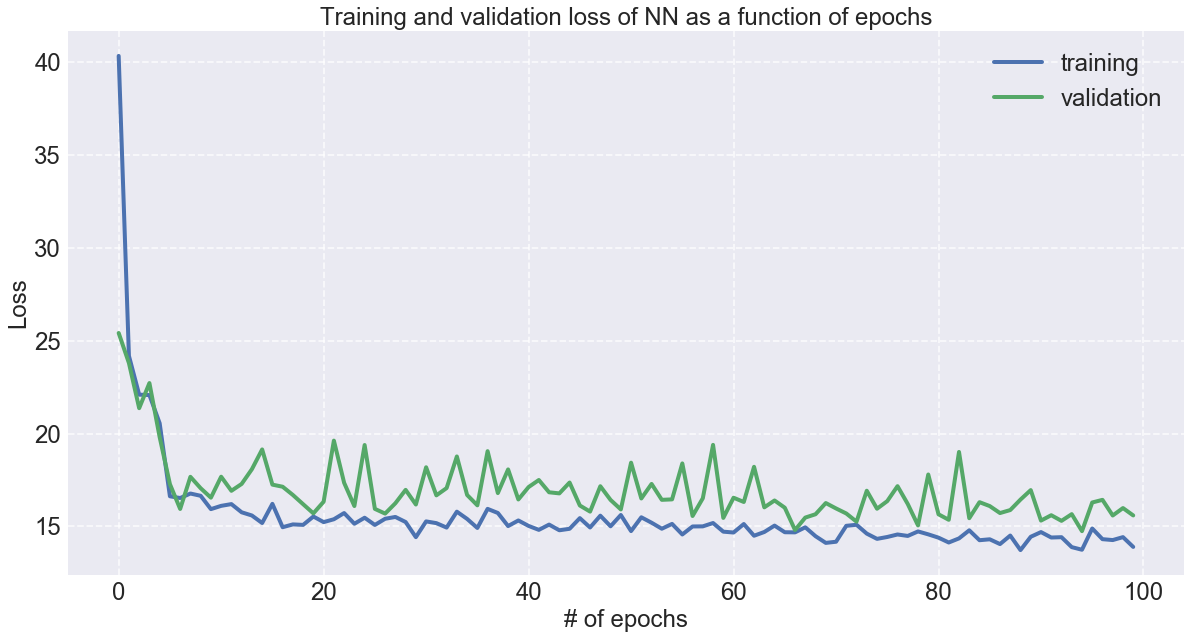

In [311]:
# plot training progress (via loss func) over epochs
fig,ax = plt.subplots(1,1)
ax.plot(model_history.epoch,model_history.history['loss'],label='training')
ax.plot(model_history.epoch,model_history.history['val_loss'],label='validation')

ax.set_xlabel('# of epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and validation loss of NN as a function of epochs')

ax.legend();

In [312]:
# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [313]:
for k, ang in enumerate(angs):
  print(ang)
  print(r2_score(y_test.values[:,k],y_pred_test[:,k]))

ab
0.7743722536696551
hf
0.6067573952164149
ir
0.7014920307049253
